<a href="https://colab.research.google.com/github/PRIMEADAWAS/CEB_Assignment/blob/main/RADI605_A6_PasitSupholkhan_(Assignment_CNN_noduleNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RADI605_A6_PasitSupholkhan (Assignment: CNN noduleNet)



# Assignment: CNN noduleNet

Develop your CNN model to classify benign and malignancy.  You have 3 weeks to finish it.
1. Use the nodulenet dataset, the data in image file where the labels were stored in csv files.
2. Data splitting was done already.  You only need to read image files to numpy array.
3. Make sure that you have set all required seeds for your experiment
4. Apply data augmentation process to generate training, validation, and test set.  Explanation in details is a must, for example, what are the image manipulation technique that you use and why did you think it is appropriate for this problem.
5. Propose your model architecture
6. Propose another model that apply transfer learning
7. Compare model at 4 and 5 with appropriate evaluation metrics.  Explain why those metrics are suitable
8. Discuss on the results why one is better than another.
9. Suggests how to improve the weaker one and do additional experiment to show that your suggestions works. 

# CNN for dectect lung nodule in CT chest

The result model were uploaded in the same folder of notebook cnnModelOld.h5, cnnModelNew.h5, vgg16Modeltf.h5

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.random.set_seed(653611)
tf.__version__, device_lib.list_local_devices(), tf.config.list_physical_devices('GPU')

('2.12.0',
 [name: "/device:CPU:0"
  device_type: "CPU"
  memory_limit: 268435456
  locality {
  }
  incarnation: 8111692381086817941
  xla_global_id: -1,
  name: "/device:GPU:0"
  device_type: "GPU"
  memory_limit: 14343274496
  locality {
    bus_id: 1
    links {
    }
  }
  incarnation: 16885136949777009175
  physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
  xla_global_id: 416903419],
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print('Pandas version :',pd.__version__)
print('Numpy version :',np.__version__)
%matplotlib inline

Pandas version : 1.4.4
Numpy version : 1.22.4


In [ ]:
# import os
import cv2
import seaborn as sns
from skimage.io import imread

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define path to the data directory
url = '/content/drive/MyDrive/Dataset/NoduleNetAssignment/'

# 1.Use the nodulenet dataset, the data in image file where the labels were stored in csv files.


## Get trainlabels, vallabels, testlabels list from text file, then separate url and label into list

In [ ]:
# Get the path to the normal and cancer sub-directories
url_trainlabels = url + 'trainlabels.txt'
url_vallabels = url + 'vallabels.txt'
url_testlabels = url + 'testlabels.txt'
url_trainlabels, url_vallabels, url_testlabels

('/content/drive/MyDrive/Dataset/NoduleNetAssignment/trainlabels.txt',
 '/content/drive/MyDrive/Dataset/NoduleNetAssignment/vallabels.txt',
 '/content/drive/MyDrive/Dataset/NoduleNetAssignment/testlabels.txt')

In [ ]:
def getDataFromFile(urlLabelText):
  # open file labels.txt
  labels_file = open(urlLabelText,'r')  
  # split all text file by \n and combine to list remove first array "image label" which is not data
  labels_list = labels_file.read().split('\n')[1:]
  # close the file
  labels_file.close()
  # split url and label then store in list
  labels_list = [i.split(' ') for i in labels_list]
  return labels_list

display sample url and label in list

In [ ]:
# use function getDataFromFile to load data from text file and display
trainlabels_list = getDataFromFile(url_trainlabels)
vallabels_list = getDataFromFile(url_vallabels)
testlabels_list = getDataFromFile(url_testlabels)
trainlabels_list[:3], vallabels_list[:3], testlabels_list[:3]

([['train/image_59270.jpg', '0'],
  ['train/image_150277.jpg', '0'],
  ['train/image_432208.jpg', '0']],
 [['val/image_450608.jpg', '0'],
  ['val/image_464772.jpg', '0'],
  ['val/image_298997.jpg', '1']],
 [['test/image_189342.jpg', '0'],
  ['test/image_145102.jpg', '0'],
  ['test/image_31546.jpg', '0']])

## Train data visualization

create pd dataframe for train data to visualization

In [ ]:
# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(trainlabels_list, columns=['imgurl', 'label'],index=None)
# concate string original url and image url
train_data['imgurl'] = url + train_data['imgurl']
# convert label column string to int
train_data['label'] = train_data['label'].astype('int')
# How the dataframe looks like?
train_data.head()

,imgurl,label
0,/content/drive/MyDrive/Dataset/NoduleNetAssign...,0
1,/content/drive/MyDrive/Dataset/NoduleNetAssign...,0
2,/content/drive/MyDrive/Dataset/NoduleNetAssign...,0
3,/content/drive/MyDrive/Dataset/NoduleNetAssign...,0
4,/content/drive/MyDrive/Dataset/NoduleNetAssign...,0


In [ ]:
train_data.info()
train_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5187 entries, 0 to 5186
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   imgurl  5187 non-null   object
 1   label   5187 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.2+ KB


(5187, 2)

barplot to show nubers of classes

0    4342
1     845
Name: label, dtype: int64


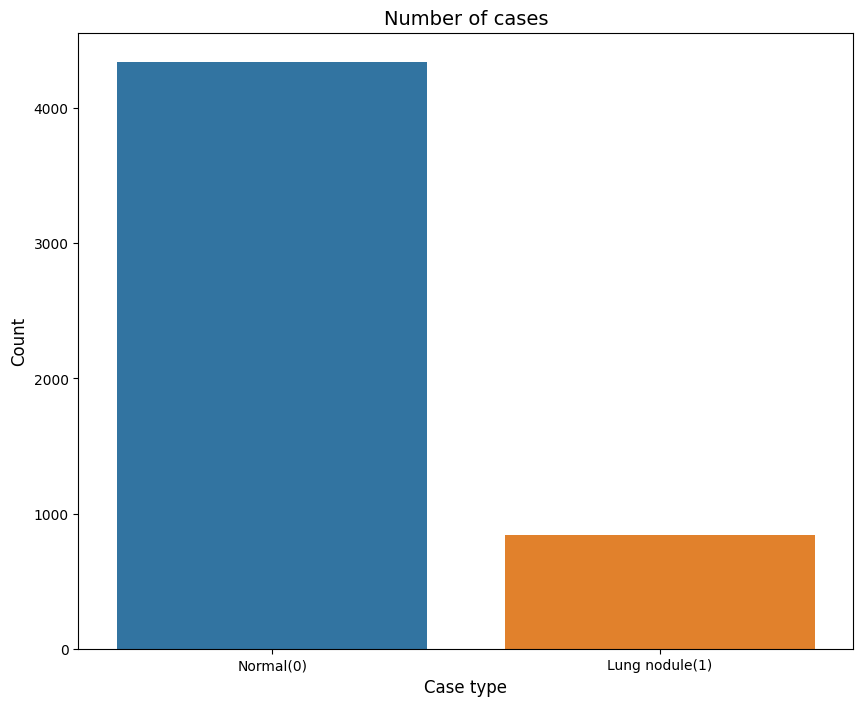

In [ ]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Lung nodule(1)'])
plt.show()

show 5 sample images of each normal and lung nodule cases.

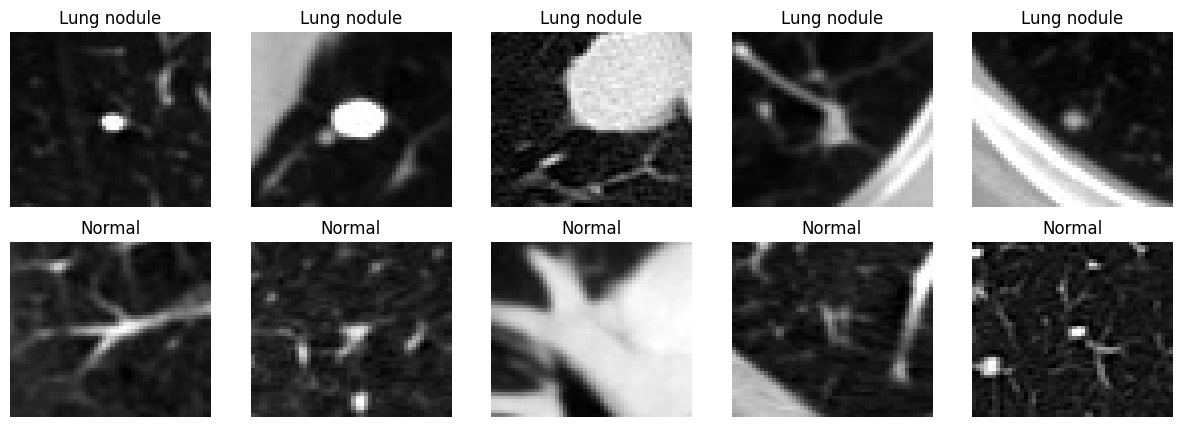

In [ ]:
# Get few samples for both the classes
Tuberculosis_samples = (train_data[train_data['label'] == 1]['imgurl'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label'] == 0]['imgurl'].iloc[:5]).tolist()

# Concat the data in a single list
samples = Tuberculosis_samples + normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(15,5))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Lung nodule")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

convert img url into 3D int array and store to column image.

# 2.Data splitting was done already. You only need to read image files to numpy array.

## Convert image file into 3d integer array

In [ ]:
# import tqdm for show progression
from tqdm import tqdm
tqdm.pandas()

In [ ]:
# function for convert image file into 3d integer array and store in list after that return its numpy
def convertImgToIntArray(labels_list):
  datas = []
  labels = []

  for index,data in tqdm(enumerate(labels_list)):
    img = cv2.imread(url+data[0],1)
    img = cv2.resize(img, (50,50))
    if img.shape[2] ==1:
      img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    # img = img/255
    label = int(data[1])
    datas.append(img)
    labels.append(label)
  
  # convert list into numpy array then return data and label
  return np.array(datas), np.array(labels)

In [ ]:
train_data, train_labels  = convertImgToIntArray(trainlabels_list)
train_data[:10], train_labels[1]

print("Total number of train data examples: ", train_data.shape)
print("Total number of labels:", train_labels.shape)

5187it [51:45,  1.67it/s]

Total number of train data examples:  (5187, 50, 50, 3)
Total number of labels: (5187,)


In [ ]:
vallabels_list
val_data, val_labels = convertImgToIntArray(vallabels_list)
val_data[:10], val_labels[1]

print("Total number of validate data examples: ", val_data.shape)
print("Total number of labels:", val_labels.shape)

1297it [13:05,  1.65it/s]

Total number of validate data examples:  (1297, 50, 50, 3)
Total number of labels: (1297,)


In [ ]:
testlabels_list
test_data, test_labels = convertImgToIntArray(testlabels_list)
test_data[:10], test_labels[1]

print("Total number of test data examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

1622it [16:02,  1.69it/s]

Total number of test data examples:  (1622, 50, 50, 3)
Total number of labels: (1622,)


show sample train_data, val_data, test_data in 3d array after converse

In [ ]:
train_data[1], val_data[1], test_data[1]

(array([[[35, 35, 35],
         [18, 18, 18],
         [19, 19, 19],
         ...,
         [20, 20, 20],
         [19, 19, 19],
         [17, 17, 17]],
 
        [[39, 39, 39],
         [22, 22, 22],
         [15, 15, 15],
         ...,
         [30, 30, 30],
         [24, 24, 24],
         [19, 19, 19]],
 
        [[40, 40, 40],
         [28, 28, 28],
         [14, 14, 14],
         ...,
         [50, 50, 50],
         [20, 20, 20],
         [12, 12, 12]],
 
        ...,
 
        [[27, 27, 27],
         [30, 30, 30],
         [37, 37, 37],
         ...,
         [17, 17, 17],
         [21, 21, 21],
         [21, 21, 21]],
 
        [[26, 26, 26],
         [23, 23, 23],
         [26, 26, 26],
         ...,
         [18, 18, 18],
         [16, 16, 16],
         [12, 12, 12]],
 
        [[46, 46, 46],
         [35, 35, 35],
         [27, 27, 27],
         ...,
         [22, 22, 22],
         [17, 17, 17],
         [12, 12, 12]]], dtype=uint8), array([[[ 29,  29,  29],
         [ 22,  2

In [ ]:
X_train = train_data
y_train = train_labels
X_test = test_data
y_test = test_labels
X_val = val_data
y_val = val_labels
X_train.shape

(5187, 50, 50, 3)

## Save preprocess file to h5

In [ ]:
import h5py

In [ ]:
hf = h5py.File(url+'NeuralnetTrain.h5', 'w')
hf.create_dataset('X_train', data=train_data)
hf.create_dataset('y_train', data=train_labels)

<HDF5 dataset "y_train": shape (5187,), type "<i8">

In [ ]:
hf.close()

In [ ]:
hf = h5py.File(url+'NeuralnetVal.h5', 'w')
hf.create_dataset('X_val', data=val_data)
hf.create_dataset('y_val', data=val_labels)

<HDF5 dataset "y_val": shape (1297,), type "<i8">

In [ ]:
hf.close()

In [ ]:
hf = h5py.File(url+'NeuralnetTest.h5', 'w')
hf.create_dataset('X_test', data=test_data)
hf.create_dataset('y_test', data=test_labels)

<HDF5 dataset "y_test": shape (1622,), type "<i8">

In [ ]:
hf.close()

## Read preprocess h5 file

In [ ]:
import h5py

In [ ]:
hf = h5py.File(url+'NeuralnetTrain.h5', 'r')
list(hf.keys())

['X_train', 'y_train']

In [ ]:
print("Loading training data ...", end="")
hf = h5py.File(url + "NeuralnetTrain.h5", "r")
X_train = np.array(hf['X_train'])
y_train = np.array(hf['y_train'])
hf.close()
print(X_train.shape,y_train.shape," Done.")

print("Loading validating data ...", end="")
hf = h5py.File(url + "NeuralnetVal.h5", "r")
X_val = np.array(hf.get("X_val"))
y_val = np.array(hf.get("y_val"))
hf.close()
print(X_val.shape,y_val.shape," Done.")


print("Loading testing data ...", end="")
hf = h5py.File(url + "NeuralnetTest.h5", "r")
X_test = np.array(hf.get("X_test"))
y_test = np.array(hf.get("y_test"))
hf.close()
print(X_test.shape,y_test.shape," Done.")


Loading training data ...(5187, 50, 50, 3) (5187,)  Done.
Loading validating data ...(1297, 50, 50, 3) (1297,)  Done.
Loading testing data ...(1622, 50, 50, 3) (1622,)  Done.


# 3.Make sure that you have set all required seeds for your experiment

In [ ]:
tf.random.set_seed(6536115)

# 4.Apply data augmentation process to generate training, validation, and test set. Explanation in details is a must, for example, what are the image manipulation technique that you use and why did you think it is appropriate for this problem.

## Image augmentation sample

use ImageDataGenerator from keres image preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

pick one image to augmentation sample

In [ ]:
# load image
filepath = train_data['imgurl'][0]
img = load_img(filepath)
# convert image to 3D array
image_data = img_to_array(img)
# convert into 4D of 3D array element
images_data = np.expand_dims(image_data, axis=0)

Image augmentation technique   
- width_shift_range=0.2, => randomly shifts the image horizontally left or right by 20% based on its original image width
- height_shift_range=0.2, => randomly shifts the image vertically up or down by 20% based on its original image height
- horizontal_flip=True, => flip the image horizontally swap to left and right
- rotation_range=10 => randomly rotates the image up to 10 degrees

Avoid
- zoom_range => cannot use because size of nodule in ct chest has impact to diagnosis, the bigger nodule mean more pathologic nodule.  
- brightness_range => The house field unit of the CT chest is affected by the change in brightness. 

In [ ]:
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             rotation_range=10
                            #  brightness_range=[0.15,0.20],
                            #  zoom_range=[0.2,0.5]
                             )
# flow create 4D array contain new image augmentation
train_generator = datagen.flow(images_data,batch_size=1)

In [ ]:
def displayImageAugment(generator):
  rows = 5
  columns = 4
  #5 rows x 4 columns plot
  fig, axes = plt.subplots(rows,columns)
  for r in range(rows):
      for c in range(columns):
          #create next image each batch (single image since batch size = 1)
          image_batch = generator.next()
          #convert to unsigned integers for display
          image = image_batch[0].astype('uint8')
          #display image
          axes[r,c].imshow(image)
  #set figure size
  fig.set_size_inches(15,10)

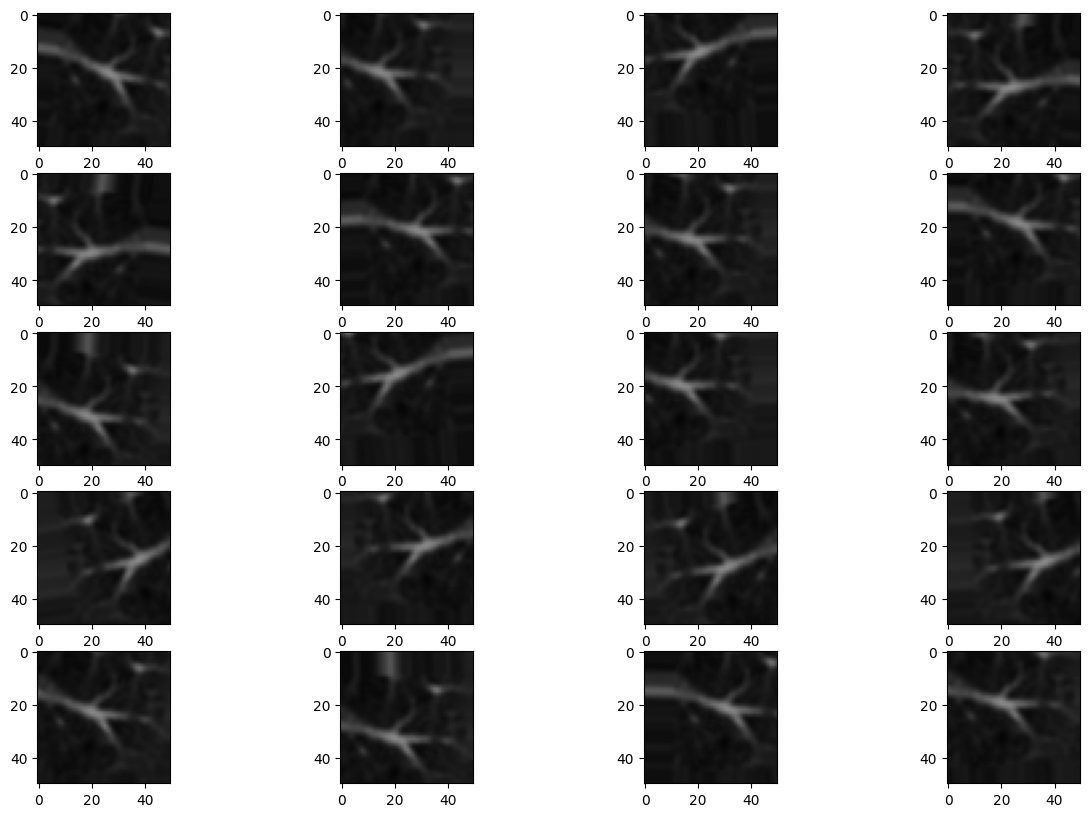

In [ ]:
displayImageAugment(train_generator)

## Move image into classes folder  

create new folder for class negative and positive

In [ ]:
import os
pathTestPositive = url + 'test/positive'
if (not os.path.exists(pathTestPositive)):
    os.mkdir(pathTestPositive)


pathTestNegative = url + 'test/negative'
if (not os.path.exists(pathTestNegative)):
    os.mkdir(pathTestNegative)

Move image data into the negative and positive folders based on the class 0 or 1 label.

In [ ]:
import os
import shutil

for index, labels_list in enumerate(testlabels_list):
    imageName = labels_list[0]
    label = labels_list[1]

    src_path = url + imageName

    if(label == "1"):
        dst_path = pathTestPositive + '/' + imageName.split('/')[1]
    elif(label == "0"):
        dst_path = pathTestNegative + '/' + imageName.split('/')[1]
        
    try:
        shutil.move(src_path, dst_path)
    except:
        pass

## Create imageDataGenerator on train, validate and test data

rescale=1/255.0 for normalize 3d image array

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create image data augmentation generator
trainDatagen = ImageDataGenerator(rescale=1/255.0,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  rotation_range=10)
# use .fit before use .flow in model.fit_generator
trainDatagen.fit(X_train)

In [ ]:
# create image data augmentation generator
valDatagen = ImageDataGenerator(rescale=1/255.0,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  rotation_range=10)
# use .fit before use .flow in model.fit_generator
valDatagen.fit(X_val)

In [ ]:
# create image data augmentation generator
testDatagen = ImageDataGenerator(rescale=1/255.0,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  rotation_range=10)
test_generator=testDatagen.flow_from_directory(url + 'test/', batch_size=32, shuffle=False, class_mode='binary', target_size=(50,50), color_mode='rgb',seed=653611)

Found 1622 images belonging to 2 classes.


In [ ]:
test_generator.class_indices

{'negative': 0, 'positive': 1}

# 5.Propose your model architecture

## CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers

model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.6))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 4, 4, 128)       

create callbacks for early stopping and save best model checkpoint

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode= 'min', patience= 10, verbose = 1)

mc = ModelCheckpoint(filepath = url+'cnnModel.h5', mode= 'min', verbose = 1, save_best_only=True)

In [ ]:
NO_EPOCHS = 300
BATCH_SIZE = 32
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(trainDatagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                              steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                              validation_data=valDatagen.flow(X_val, y_val, batch_size=BATCH_SIZE),
                              validation_steps=X_val.shape[0] // BATCH_SIZE,
                              epochs=NO_EPOCHS, 
                              verbose = 1, 
                              callbacks=[es,mc])

Epoch 1/300


<ipython-input-160-66bd36702134>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(trainDatagen.flow(X_train, y_train, batch_size=BATCH_SIZE),


161/162 [============================>.] - ETA: 0s - loss: 0.6107 - accuracy: 0.6933
Epoch 1: val_loss improved from inf to 0.47855, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel4.h5
162/162 [==============================] - 18s 82ms/step - loss: 0.6100 - accuracy: 0.6943 - val_loss: 0.4785 - val_accuracy: 0.8273
Epoch 2/300
162/162 [==============================] - ETA: 0s - loss: 0.4673 - accuracy: 0.8200
Epoch 2: val_loss improved from 0.47855 to 0.43374, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel4.h5
162/162 [==============================] - 10s 62ms/step - loss: 0.4673 - accuracy: 0.8200 - val_loss: 0.4337 - val_accuracy: 0.8297
Epoch 3/300
161/162 [============================>.] - ETA: 0s - loss: 0.4374 - accuracy: 0.8341
Epoch 3: val_loss did not improve from 0.43374
162/162 [==============================] - 9s 58ms/step - loss: 0.4370 - accuracy: 0.8345 - val_loss: 0.4434 - val_accuracy: 0.8258
Epoch 4/300
161/

## Model evaluation

In [ ]:
def plotLoss(modelHistory):
  plt.plot(modelHistory.history['loss'])
  plt.plot(modelHistory.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

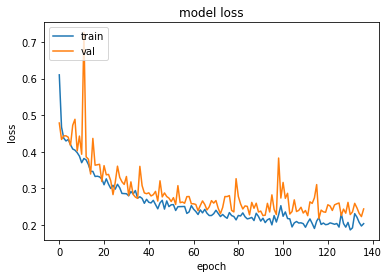

In [ ]:
plotLoss(history)

In [ ]:
def plotAccuracy(modelHistory):
  plt.plot(modelHistory.history['accuracy'])
  plt.plot(modelHistory.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

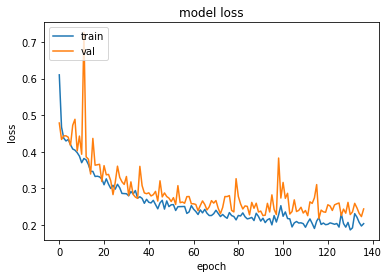

In [ ]:
plotLoss(history)

## Load model

In [ ]:
# compile = False to prevent reset model parameters
from tensorflow.keras.models import load_model
cnnModel = models.load_model(url+'cnnModelOld.h5', compile = False)

In [ ]:
from sklearn.metrics import roc_curve, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
def probToClass(model):
    # get predict probaility from model
    predictProb = model.predict(test_generator)

    # find thresholds and convert to predictClass {'negative': 0, 'positive': 1}
    fpr, tpr, thresholds = roc_curve(y_true=test_generator.classes, y_score=predictProb, pos_label=1)
    idx = np.argmax(np.abs(tpr - fpr))
    optimal_threshold = thresholds[idx]
    predictClass = (predictProb[:, 0] >= optimal_threshold).astype(int)
    return predictClass

def modelEvaluate(model):
    predictClass = probToClass(model) 

    # plot confusion matrix
    print("Accuracy score is: ",accuracy_score(test_generator.classes,predictClass))
    print("Recall score is: ",recall_score(test_generator.classes,predictClass))
    print("F1 score is: ",f1_score(test_generator.classes,predictClass))
    print("Confusion Matrix: \n",pd.DataFrame(confusion_matrix(test_generator.classes, predictClass)))
    ConfusionMatrixDisplay(confusion_matrix(test_generator.classes, predictClass), display_labels=['Normal','LungNodule']).plot()
    print(classification_report(test_generator.classes, predictClass, target_names = ['Normal (Class 0)','Lung Nodule(Class 1)']))

51/51 [==============================] - 5s 88ms/step
Accuracy score is:  0.8785450061652281
Recall score is:  0.8865248226950354
F1 score is:  0.7173601147776183
Confusion Matrix: 
       0    1
0  1175  165
1    32  250
                      precision    recall  f1-score   support

    Normal (Class 0)       0.97      0.88      0.92      1340
Lung Nodule(Class 1)       0.60      0.89      0.72       282

            accuracy                           0.88      1622
           macro avg       0.79      0.88      0.82      1622
        weighted avg       0.91      0.88      0.89      1622



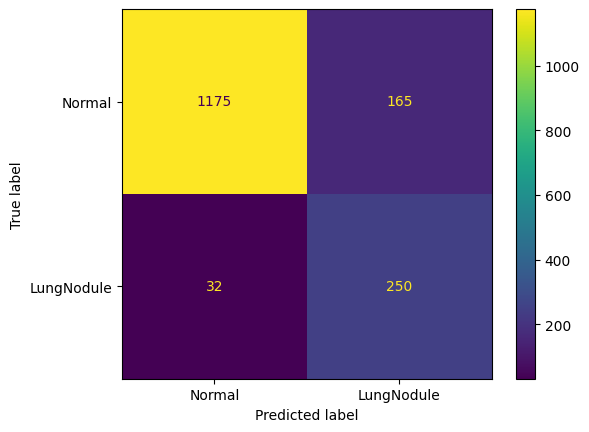

In [ ]:
modelEvaluate(cnnModel)

In [ ]:
def showTrueAns(model):
  prediction = probToClass(model) 
  y_test = test_generator.classes
  
  correct = np.nonzero(prediction == y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in correct[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

51/51 [==============================] - 8s 152ms/step


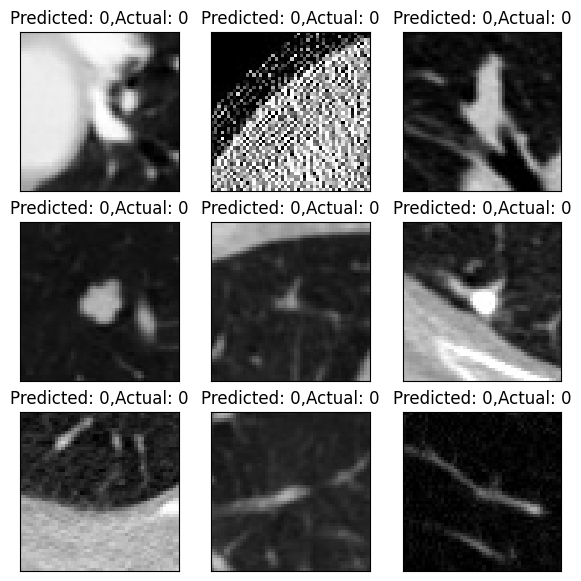

In [ ]:
showTrueAns(cnnModel)

In [ ]:
def showFalseAns(prediction):
  prediction = probToClass(model) 
  y_test = test_generator.classes
  
  incorrect = np.nonzero(prediction != y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in incorrect[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

51/51 [==============================] - 4s 72ms/step


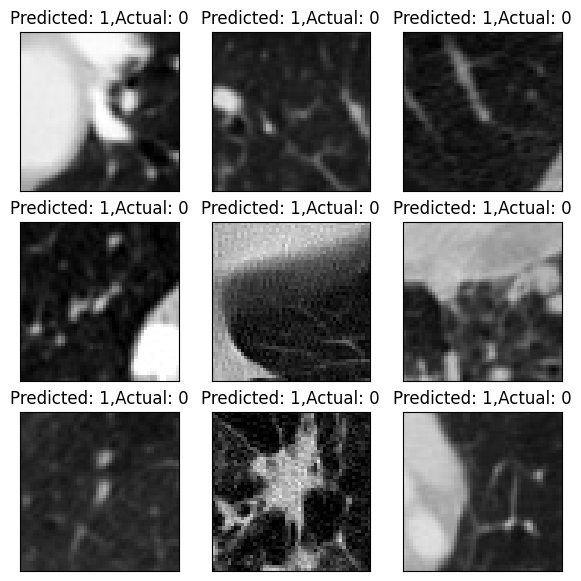

In [ ]:
showFalseAns(cnnModel)

# 6.Propose another model that apply transfer learning

### VGG 16 model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model,Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

create input shape from image shape then  
import vgg16 model wihout top layer(flatten and dense)


In [ ]:
height = 50
width = 50
depth = 3
# create input shape from image shape
input_shape = (height,width,depth)

# import vgg16 model wihout top layer(flatten and dense)
pretrain = VGG16(weights='imagenet', 
                 include_top = False, 
                 input_shape=input_shape)

Tranfer learning by adding flatten, dense and sigmoid layers to combine with vgg16 without top layers add regularization BatchNormalization and Dropout(0.2) between each Dense layers, use learning_rate=0.00001

In [ ]:
# to use tranfer learning create own flatten, dense and sigmoid layers to combine with vgg16 without top layers
model = Sequential()
model.add(pretrain)
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001), metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               65664     
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                      

create callbacks for early stopping and save best model checkpoint

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode= 'min', patience= 10, verbose = 1)

mc = ModelCheckpoint(filepath = url+'vgg16Modeltf.h5', mode= 'min', verbose = 1, save_best_only=True)

In [ ]:
NO_EPOCHS = 300
BATCH_SIZE = 64
history = model.fit_generator(trainDatagen.flow(X_train, y_train, batch_size=BATCH_SIZE,shuffle=True),
                              steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                              validation_data=valDatagen.flow(X_val, y_val, batch_size=BATCH_SIZE,shuffle=True),
                              validation_steps=X_val.shape[0] // BATCH_SIZE,
                              epochs=NO_EPOCHS, 
                              verbose = 1, 
                              callbacks=[es,mc])

Epoch 1/300


<ipython-input-152-446dcc9712d5>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(trainDatagen.flow(X_train, y_train, batch_size=BATCH_SIZE,shuffle=True),


81/81 [==============================] - ETA: 0s - loss: 0.4926 - accuracy: 0.7724
Epoch 1: val_loss improved from inf to 0.65080, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/vgg16Model3.h5
81/81 [==============================] - 15s 109ms/step - loss: 0.4926 - accuracy: 0.7724 - val_loss: 0.6508 - val_accuracy: 0.6422
Epoch 2/300
81/81 [==============================] - ETA: 0s - loss: 0.3059 - accuracy: 0.8877
Epoch 2: val_loss improved from 0.65080 to 0.42415, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/vgg16Model3.h5
81/81 [==============================] - 9s 110ms/step - loss: 0.3059 - accuracy: 0.8877 - val_loss: 0.4242 - val_accuracy: 0.9023
Epoch 3/300
81/81 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.9079
Epoch 3: val_loss improved from 0.42415 to 0.30987, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/vgg16Model3.h5
81/81 [==============================] - 10s 121ms/step - loss: 0.

## Model evaluation

Plot loss and accuracy graph

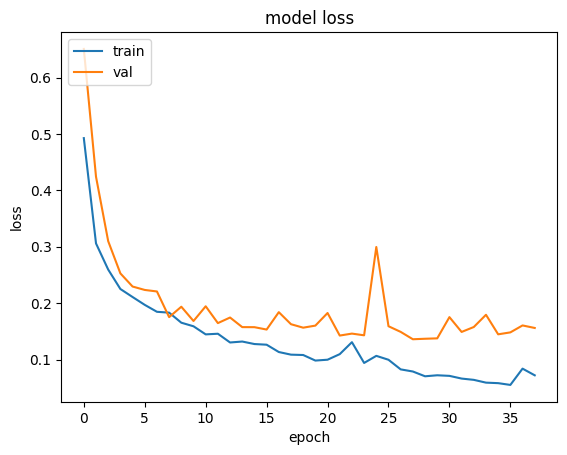

In [ ]:
plotLoss(history)

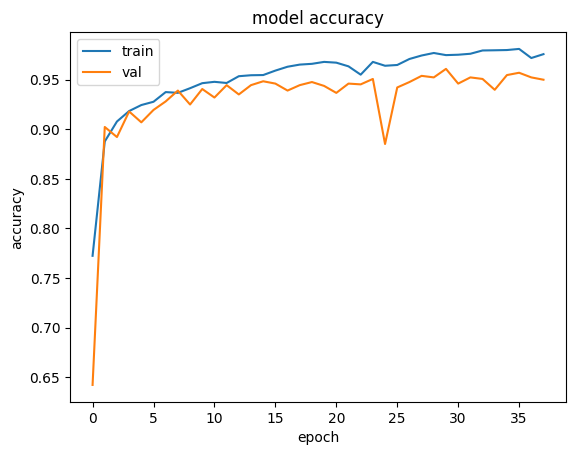

In [ ]:
plotAccuracy(history)

## Load Model 

In [ ]:
vggModel = load_model(url + 'vgg16Modeltf.h5', compile = False)
# compile False prevent reset model

51/51 [==============================] - 4s 82ms/step
Accuracy score is:  0.9321824907521579
Recall score is:  0.925531914893617
F1 score is:  0.8259493670886074
Confusion Matrix: 
       0    1
0  1251   89
1    21  261
                      precision    recall  f1-score   support

    Normal (Class 0)       0.98      0.93      0.96      1340
Lung Nodule(Class 1)       0.75      0.93      0.83       282

            accuracy                           0.93      1622
           macro avg       0.86      0.93      0.89      1622
        weighted avg       0.94      0.93      0.93      1622



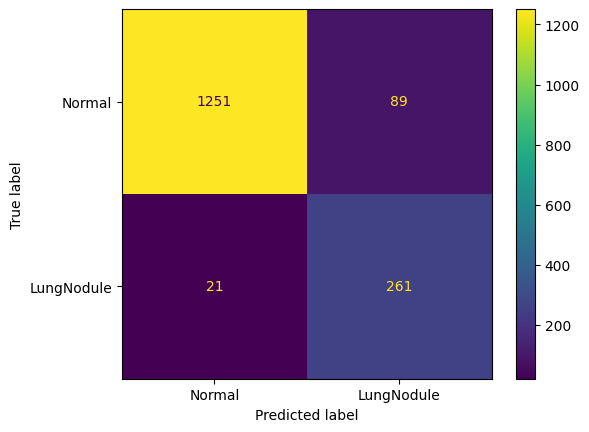

In [ ]:
modelEvaluate(vggModel)

51/51 [==============================] - 4s 72ms/step


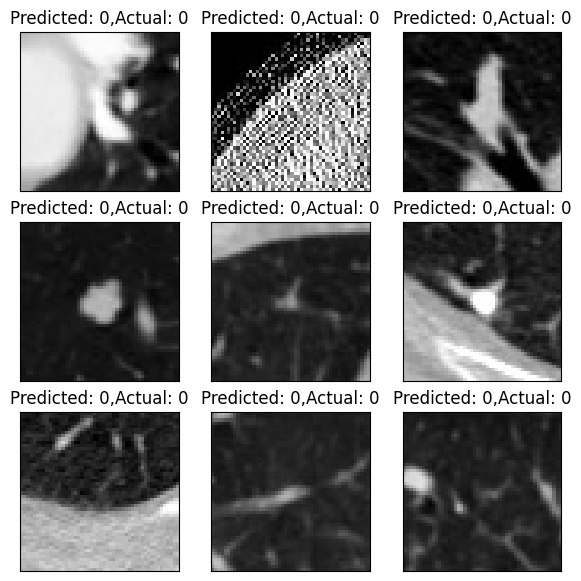

In [ ]:
showTrueAns(vggModel)

51/51 [==============================] - 4s 70ms/step


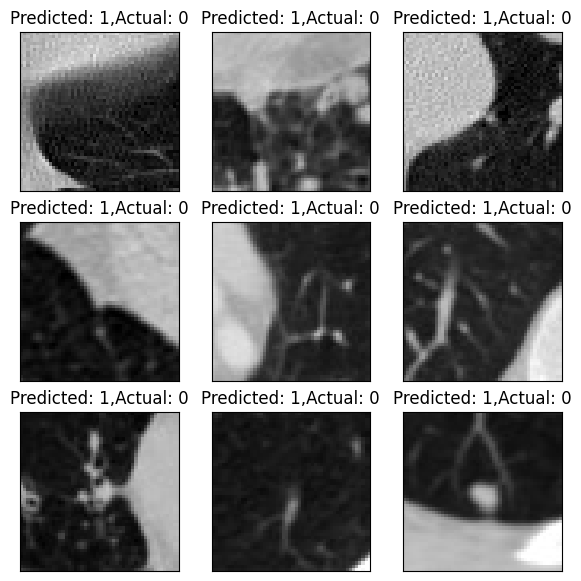

In [ ]:
showFalseAns(vggModel)

# 7.Compare model at 4 and 5 with appropriate evaluation metrics.  Explain why those metrics are suitable  
# 8.Discuss on the results why one is better than another.

Prediction lung nodule disease should focus on recall score(sensitivity) mainly to minimized false negative and prevent miss diagnosis as well as focus on f1 score for an imbalace class.

Recall score from CNN equal 89% while 93%  on VGG16 transfer model which is better.  
In addition, f1 score equal 72% in CNN and 83% on vgg16 which is better as well

CNN model trend to be overfit we will adjust model to improve report score

Confusion Matrix for CNN model

51/51 [==============================] - 5s 88ms/step
Accuracy score is:  0.8785450061652281
Recall score is:  0.8865248226950354
F1 score is:  0.7173601147776183
Confusion Matrix: 
       0    1
0  1175  165
1    32  250
                      precision    recall  f1-score   support

    Normal (Class 0)       0.97      0.88      0.92      1340
Lung Nodule(Class 1)       0.60      0.89      0.72       282

            accuracy                           0.88      1622
           macro avg       0.79      0.88      0.82      1622
        weighted avg       0.91      0.88      0.89      1622



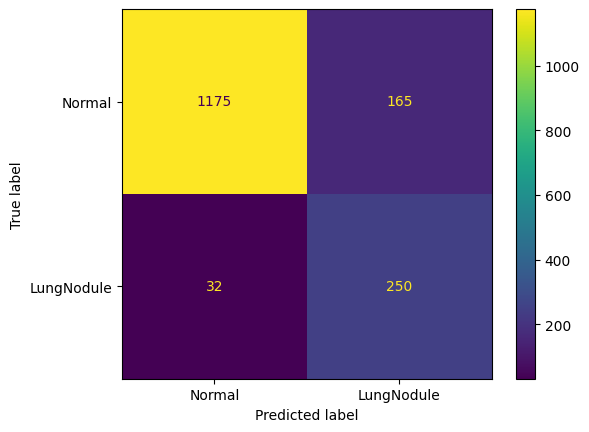

In [ ]:
modelEvaluate(cnnModel)

Confusion Matrix for vgg16Model transfer learning

51/51 [==============================] - 4s 70ms/step
Accuracy score is:  0.9321824907521579
Recall score is:  0.925531914893617
F1 score is:  0.8259493670886074
Confusion Matrix: 
       0    1
0  1251   89
1    21  261
                      precision    recall  f1-score   support

    Normal (Class 0)       0.98      0.93      0.96      1340
Lung Nodule(Class 1)       0.75      0.93      0.83       282

            accuracy                           0.93      1622
           macro avg       0.86      0.93      0.89      1622
        weighted avg       0.94      0.93      0.93      1622



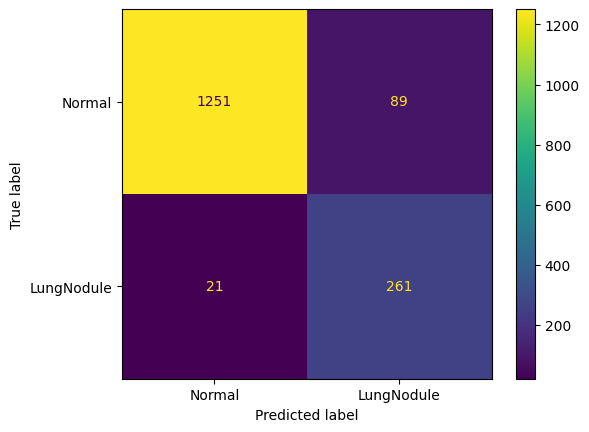

In [ ]:
modelEvaluate(vggModel)

# 9.Suggests how to improve the weaker one and do additional experiment to show that your suggestions works.

# New CNN model  
previous CNN model trend to be over fit(1M parameter) to solve this problem should
decrease model parameter(to 367,297) together with add BatchNormalization as well as Dropout layers between each Dense layers.

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 4, 4, 128)      

create callbacks for early stopping and save best model checkpoint

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode= 'min', patience= 20, verbose = 1)

mc = ModelCheckpoint(filepath = url+'cnnModelNew.h5', mode= 'min', verbose = 1, save_best_only=True)

In [ ]:
NO_EPOCHS = 400
BATCH_SIZE = 128

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(trainDatagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                              steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                              validation_data=valDatagen.flow(X_val, y_val, batch_size=BATCH_SIZE),
                              validation_steps=X_val.shape[0] // BATCH_SIZE,
                              epochs=NO_EPOCHS, 
                              verbose = 1, 
                              callbacks=[es,mc])

Epoch 1/400


<ipython-input-115-d89375a701db>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(trainDatagen.flow(X_train, y_train, batch_size=BATCH_SIZE),


40/40 [==============================] - ETA: 0s - loss: 0.7250 - accuracy: 0.6017
Epoch 1: val_loss improved from inf to 0.57334, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel7.h5
40/40 [==============================] - 12s 188ms/step - loss: 0.7250 - accuracy: 0.6017 - val_loss: 0.5733 - val_accuracy: 0.8266
Epoch 2/400
40/40 [==============================] - ETA: 0s - loss: 0.5859 - accuracy: 0.7094
Epoch 2: val_loss improved from 0.57334 to 0.48781, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel7.h5
40/40 [==============================] - 8s 188ms/step - loss: 0.5859 - accuracy: 0.7094 - val_loss: 0.4878 - val_accuracy: 0.8320
Epoch 3/400
40/40 [==============================] - ETA: 0s - loss: 0.5187 - accuracy: 0.7632
Epoch 3: val_loss improved from 0.48781 to 0.45030, saving model to /content/drive/MyDrive/Dataset/NoduleNetAssignment/cnnModel7.h5
40/40 [==============================] - 5s 133ms/step - loss: 0.5187 - 

## Model evaluation

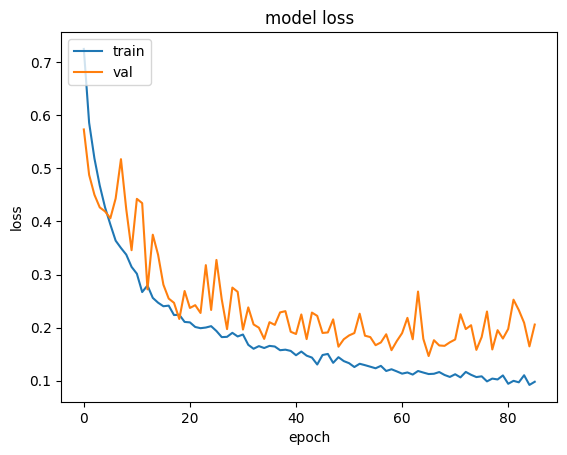

In [ ]:
plotLoss(history)

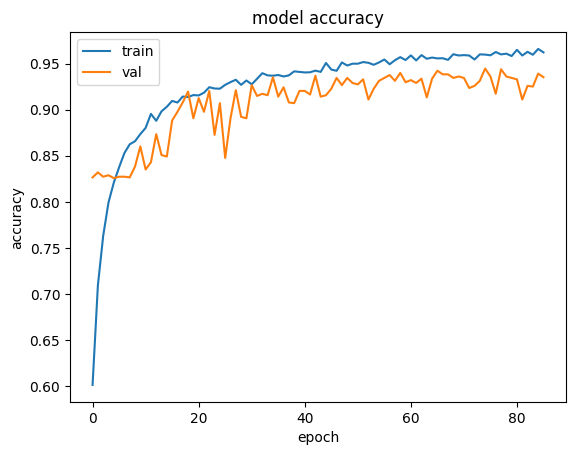

In [ ]:
plotAccuracy(history)

## Load model

In [ ]:
# compile = False to prevent reset model parameters
cnnModelNew = models.load_model(url+'cnnModelNew.h5', compile = False)

In [ ]:
predictCNN = cnnModelNew.predict_generator(X_test/255.0)
predictCNN

<ipython-input-82-c6ad4d920f2e>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictCNN = cnnModelNew.predict_generator(X_test/255.0)


array([[5.1022959e-01],
       [1.6070310e-04],
       [1.7521916e-03],
       ...,
       [2.0447376e-01],
       [2.6851913e-03],
       [4.3304634e-04]], dtype=float32)

In [ ]:
def probToClass(prob):
  from sklearn.metrics import roc_curve

  fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=prob, pos_label=1)
  idx = np.argmax(np.abs(tpr - fpr))
  optimal_threshold = thresholds[idx]

  yhat = (prob[:, 0] >= optimal_threshold).astype(int)
  return yhat

In [ ]:
predictClassCNN = probToClass(predictCNN)
predictClassCNN, y_test

(array([1, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

Accuracy score is:  0.9469790382244143
Recall score is:  0.9361702127659575
F1 score is:  0.8599348534201954
Confusion Matrix: 
       0    1
0  1272   68
1    18  264
                      precision    recall  f1-score   support

    Normal (Class 0)       0.99      0.95      0.97      1340
Lung Nodule(Class 1)       0.80      0.94      0.86       282

            accuracy                           0.95      1622
           macro avg       0.89      0.94      0.91      1622
        weighted avg       0.95      0.95      0.95      1622



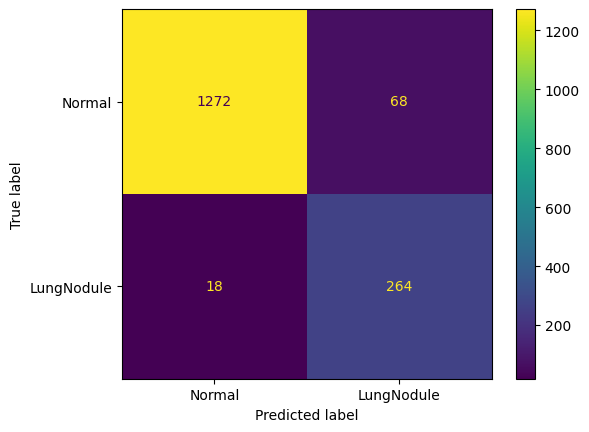

In [ ]:
print("Accuracy score is: ",accuracy_score(y_test,predictClassCNN))
print("Recall score is: ",recall_score(y_test,predictClassCNN))
print("F1 score is: ",f1_score(y_test,predictClassCNN))
print("Confusion Matrix: \n",pd.DataFrame(confusion_matrix(y_test, predictClassCNN)))
ConfusionMatrixDisplay(confusion_matrix(y_test, predictClassCNN), display_labels=['Normal','LungNodule']).plot()
print(classification_report(y_test, predictClassCNN, target_names = ['Normal (Class 0)','Lung Nodule(Class 1)']))

In [ ]:
def showTrueAns(prediction):
  correct = np.nonzero(prediction == y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in correct[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

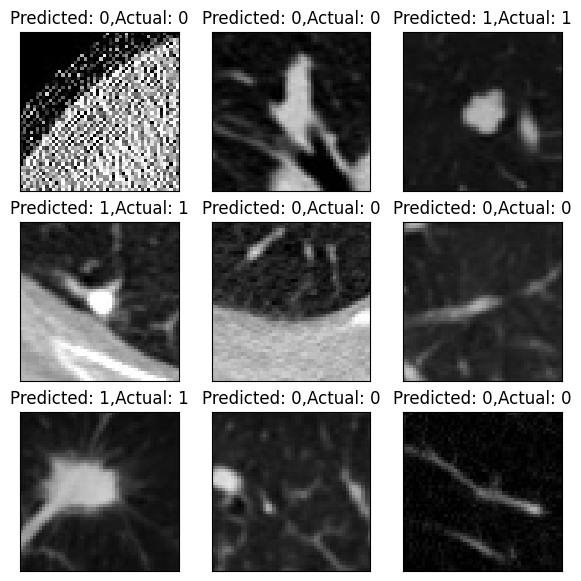

In [ ]:
showTrueAns(predictClassCNN)

In [ ]:
def showFalseAns(prediction):
  incorrect = np.nonzero(prediction != y_test)[0]
  i = 0
  plt.figure(figsize = (7,7))
  for c in incorrect[:9]:
      plt.subplot(3,3,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(X_test[c], cmap="gray", interpolation='none')
      plt.title("Predicted: {},Actual: {}".format(prediction[c], y_test[c]))
      i += 1

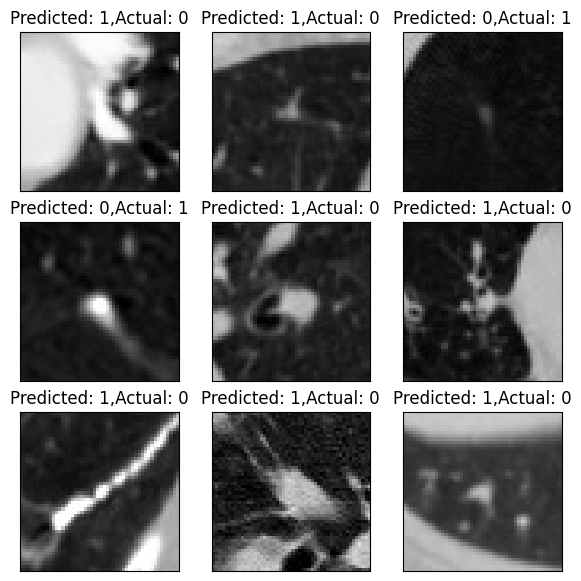

In [ ]:
showFalseAns(predictClassCNN)